# ARMA, ARIMA, SARIMA
<br>
<div style="text-align: center">
    <img src="media/cover.png" style="width: 40%"\>
</div>

## Overview

- In the previous four lessons, we learned about stationarity, smoothing, trend, seasonality, and autocorrelation, and you built two different kinds of models: 

> **MA models**: The current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.

> **AR models**: The current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).
  
- In this lesson we will review these concepts and combine the AR and MA models into three more complicated ones: ARMA, ARIMA, and SARIMA.

In particular, we will cover:

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

In [146]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)                

---

## ARMA

The ARMA model (also known as the *Box-Jenkins* approach) combines two models:

- An autoregressive (AR) model of order $p$.
- A moving average (MA) model of order $q$.

- When we have autocorrelation between outcomes and their ancestors, there will be a pattern in the time series. 
- This relationship can be modeled using an ARMA model. 
- It allows us to predict the future with a confidence level proportional to the strength of the relationship and the proximity to known values (prediction weakens the further out we go).

**📝 Note**

- ARMA models assume the time series is assumed to be stationary.
- A good rule of thumb is to have at least 100 observations when fitting an ARMA model.

### Time Series Modeling Process

Model selection is driven by the Trend and Seasonal components of our raw data. 

The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
2. Determine if we have additive or multiplicative data patterns
3. Select the appropriate algorithm based on the chart below

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
Simple Exponential Smoothing |||
Double Exponential Smoothing |X||
Triple Exponential Smoothing |X|X|
ARIMA |X|X|X

### Load data

In the following, we'll be looking at the monthly average temperatures between 1907-1972.

In [3]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1', 
                           skipfooter=2, 
                           header=0, 
                           index_col=0, 
                           names=['month', 'temp'],
                           engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

This is how the data look like

In [4]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


These are some statistics

In [5]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


Plot the data

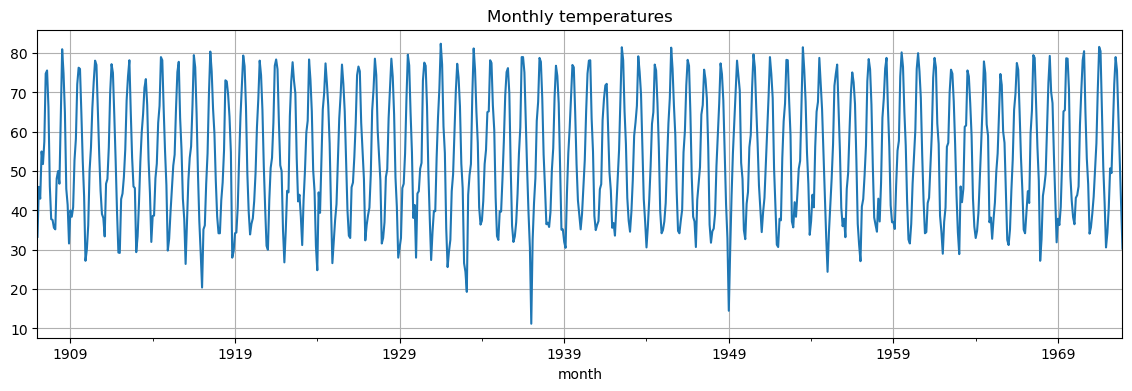

In [6]:
monthly_temp['temp'].plot(grid=True, figsize=(14, 4), title="Monthly temperatures");

Compute the annual mean and plot it on top of the actual data

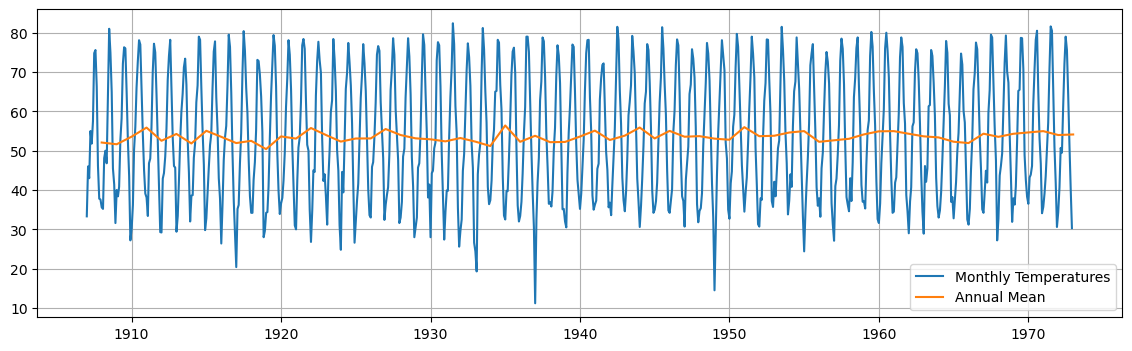

In [16]:
# Compute annual mean 
annual_temp = monthly_temp.resample('YE').mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(14, 4))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- This gives us an indication that the mean is rather constant over the years.
- We can extract further information abouth the underlying trend and seasonality by performing a seasonal decomposition.
- We can use both the `seasonal_decompose` and the `STL` methods.

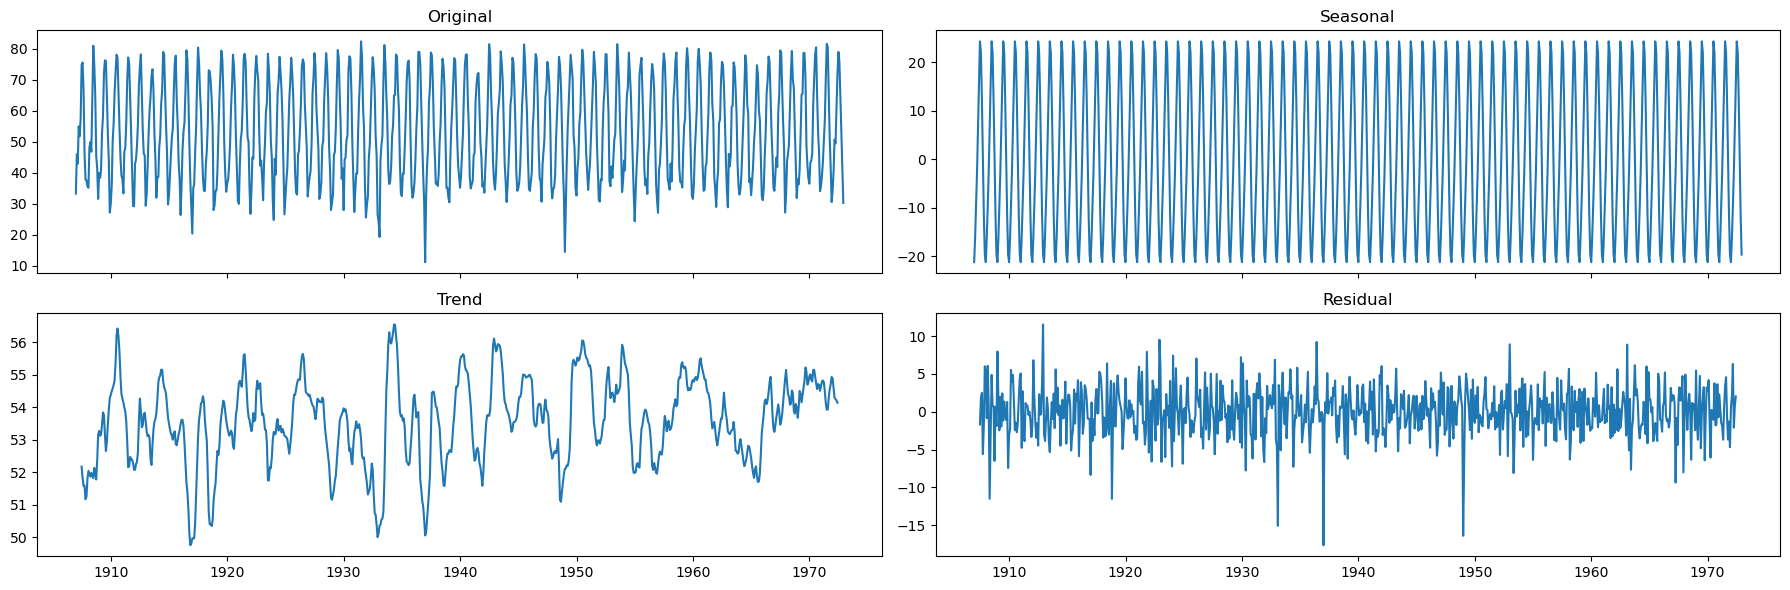

In [12]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

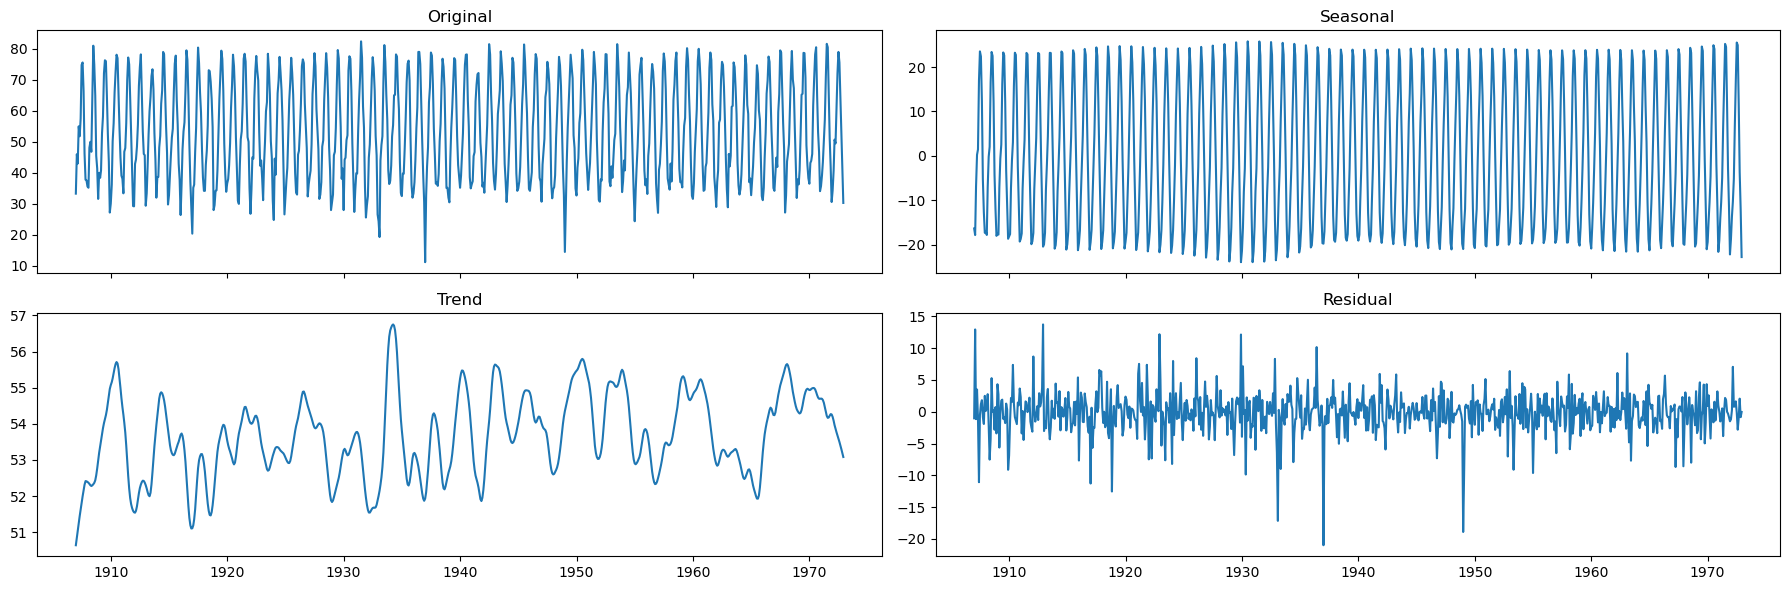

In [13]:
decomposition = STL(endog=monthly_temp['temp'], period=12, seasonal=13, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

- The seasonality is well defined.
- It doesn't seem to be a strong, time-varying trend in the data.
    - We can assume the trend is constant.
    
---

## ARMA Model Stages

There are three stages in building an ARMA model:

1. Model identification
2. Model estimation
3. Model evaluation

### Model Identification

- Model identification consists in finding the orders $p$ and $q$ AR and MA components.
- Before performing model identification we need to:
    1. Determine if the time series is stationary.
    2. Determine if the time series has seasonal component.

#### Determine Stationarity

- We will use tools we already know (ADF test).
- We can also look at the rolling mean and std.

<br>
<div style="text-align: center; font-size: 30px; font-weight: bold;">⚠ Attention! ⚠</div>
<br>

- Before we continue, let's consider the following result

In [9]:
sinusoid = np.sin(np.arange(200))
_, pvalue, _, _, _, _ = adfuller(sinusoid)
print(f'p-value: {pvalue}')

p-value: 0.0


- Periodic signals, by their nature, have means and variances that repeat over the period of the cycle. 
- This implies that their statistical properties are functions of time within each period. 
- For instance, the mean of a periodic signal over one cycle may be constant.
- However, when considering any point in time relative to the cycle, the instantaneous mean of the signal can vary. 
- Similarly, the variance can fluctuate within the cycle.

- The ADF test specifically looks for a *unit root* (more on this later on).
- A unit root indicates that shocks to the time series have a permanent effect, causing drifts in the level of the series. 
- A sinusoidal function, by contrast, is inherently *mean-reverting* within its cycles.
- After a peak a sinusoid reverts to its mean and any "shock" in terms of phase shift or amplitude change does not alter its oscillatory nature.

- It's crucial to note that the ADF test's conclusion of stationarity for a sinusoid does not imply that the sinusoid is stationary. 
- The test's conclusion is about the absence of a unit root.
- This does not imply that the mean and variance are constant within the periodic fluctuations.

---

In [17]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

ADF Statistic: -6.48
p-value: 0.000
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



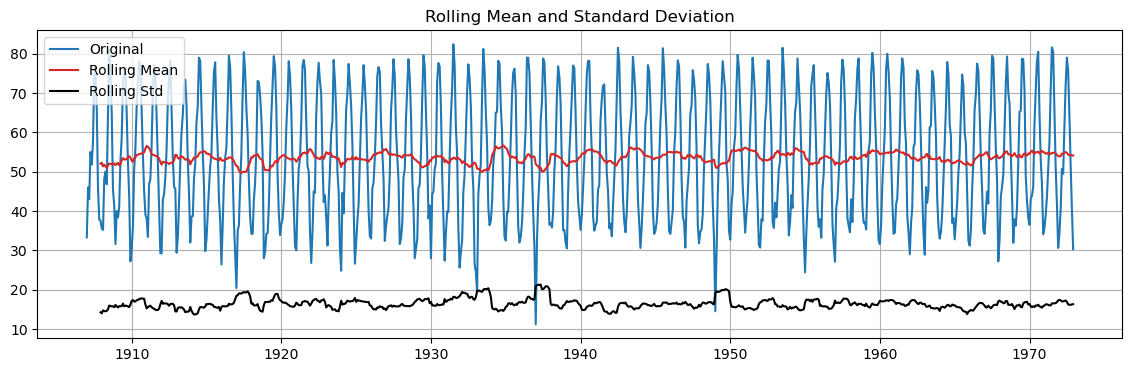

In [18]:
# run ADF on monthly temperatures
adftest(monthly_temp.temp)

- The p-value indicates that the time series is stationary...
- ... even if it clearly has a periodic component.
- The rolling mean and rolling standard deviation seem globally constant along the time series...
- ... even if they change locally within the period.

#### Determine Seasonality

Determine whether seasonality is present by using the following tools:
- Autocorrelation plot.
- Seasonal subseries plot (month plot).
- Fourier Transform

In [12]:
# run ADF on annual means
adftest(annual_temp.temp, plots=False) # no point in plotting the rolling mean/std here

ADF Statistic: -7.88
p-value: 0.000
Critical Values: ['1%: -3.54', '5%: -2.91', '10%: -2.59']



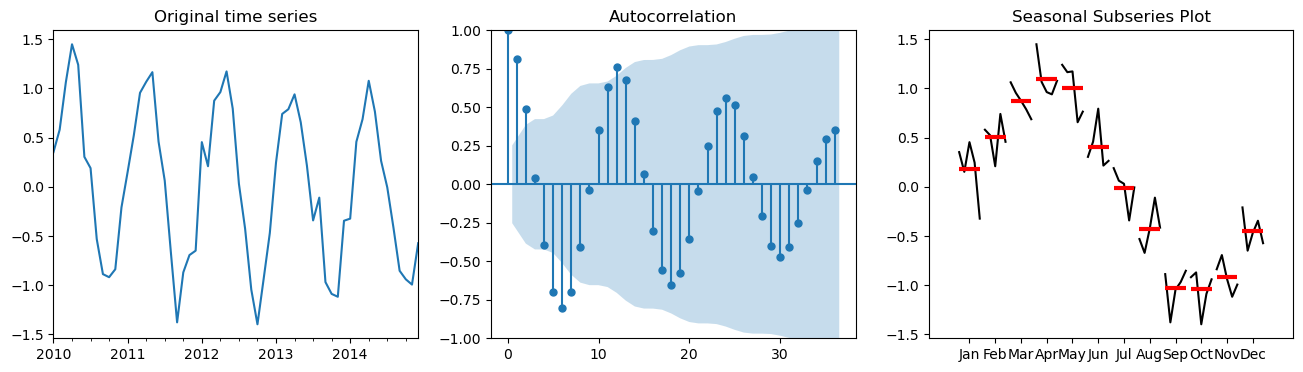

In [19]:
# Generate synthetic time series data
dates = pd.date_range(start='2010-01-01', periods=60, freq='ME')  # Monthly data for 5 years
seas = 12 # change this and see how the plots change
data = np.sin(np.arange(60)*2*np.pi/seas) + np.random.normal(loc=0, scale=0.2, size=60)  # Seasonal data with noise
series = pd.Series(data, index=dates)
fig, axes = plt.subplots(1,3,figsize=(16,4))
series.plot(ax=axes[0], title="Original time series")

# ACF Plot
plot_acf(series, lags=36, ax=axes[1]);

# Convert series to a DataFrame and add a column for the month
df = series.to_frame(name='Value')
df['Month'] = df.index.month

# Seasonal Subseries Plot
month_plot(df['Value'], ax=axes[2]); axes[2].set_title("Seasonal Subseries Plot");

- Let's look at the real data now.

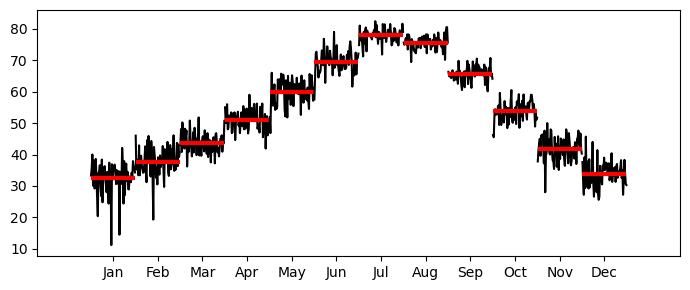

In [35]:
_, ax = plt.subplots(1,1, figsize=(7,3))
month_plot(monthly_temp, ax=ax)
plt.tight_layout();

- Notice that a `violinplot` can give a very similar information to the `month_plot`.

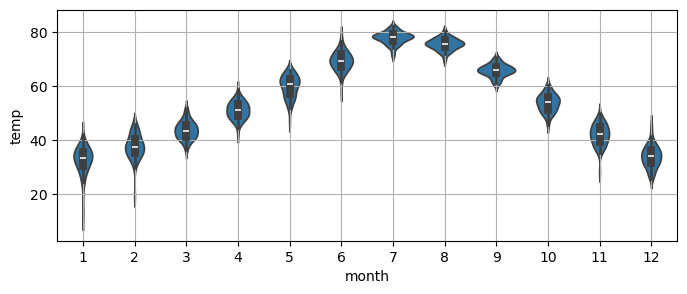

In [33]:
_, ax = plt.subplots(1,1, figsize=(8,3))
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.grid();

- Finally, to obtain the numerical value of the main periodicity we can use the Foruier Transfrom (more on this later).
- Here, we'll use the function we defined in the first lecture.

In [36]:
def fft_analysis(signal):
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 

    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    return dominant_period, positive_frequencies, magnitudes

fft_analysis(monthly_temp['temp'].values);

Dominant Period: 12.00 time units


#### Remove the main seasonality

- In this case, it is clear that the main seasonality is $L=12$.
- We can remove it with a seasonal differencing.

In [37]:
monthly_temp['Seasonally_Differenced'] = monthly_temp['temp'].diff(12)

In [38]:
# Drop nan
monthly_temp_clean = monthly_temp.dropna()
monthly_temp_clean 

,temp,Seasonally_Differenced
month,,
1908-01-01,35.6,2.3
1908-02-01,35.2,-10.8
1908-03-01,48.1,5.1
1908-04-01,50.0,-5.0
1908-05-01,46.8,-5.0
...,...,...
1972-08-01,75.6,-4.9
1972-09-01,64.1,-1.7
1972-10-01,51.7,0.6


**⚙ Try it yourself**

- Try redoing the previous plots on the differenced data!

#### Identifying $p$ and $q$

As we learned in the previous lesson, we will identify the AR order $p$ and the MA order $q$ with:

- Autocorrelation plot.
- Partial autocorrelation plot.

**AR($p$)**

- The order of the AR model is identified as follows:
    - Plot 95% confidence interval on the PACF (done automatically by statsmodels).
    - Choose lag $p$ such that partial autocorrelation becomes insignificant for $p+1$ and beyond.

- If a process depends on previous values of itself then it is an AR process. 
- If it depends on previous errors than it is an MA process.
- An AR process propagates shocks infinitely.
- AR processes will exhibit exponential decay in ACF and a cut-off in PACF.

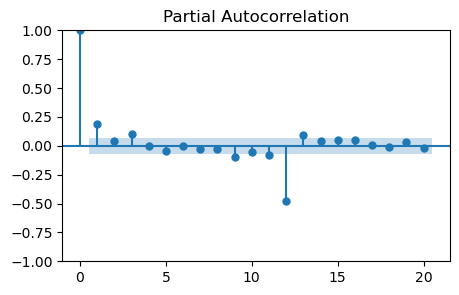

In [42]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax); 

- It looks like the PACF becomes zero at lag 2.
- However there is a non-zero partial autocorrelation at lag 3.
- The optimal value might be $p=1$, $p=2$, or $p=3$.
- Note that there are high partial autocorrelations at higher lags, especially 12. 
    - This is an effect from seasonality and seasonal differencing. 
    - It should not be accounted when chosing $p$.

**MA($q$)**

- The order of the MA model is identified as follows
    - Plot 95% confidence interval on the ACF (done automatically by statsmodels).
    - Choose lag $q$ such that autocorrelation becomes statistically zero for $q+1$ and beyond.

- MA models do not propagate shocks infinitely; they die after $q$ lags.
- MA processes will exhibit exponential decay in PACF and a cut-off in ACF

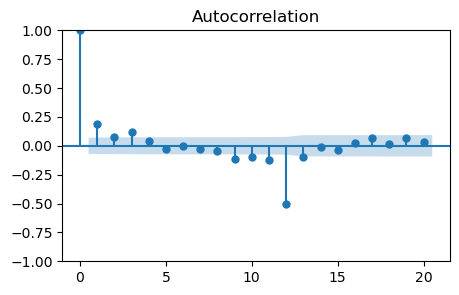

In [44]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax); 

- As for the PACF, there are non-zero autocorrelations at lags 1 and 3.
- So, the values to try are $q=1$, $q=2$, or $q=3$.

### Model estimation

- Once the orders $p$ and $q$ are identified, it's time to estimate the parameters $\phi_1, \dots, \phi_p$ or the AR part the the parameters $\theta_1, \dots, \theta_q$ of the MA part.
- Estimating the parameters of an ARMA model is a complicated, nonlinear problem.
- Nonlinear least squares and maximum likelihood e stimation (MLE) are common approaches.
- Many modern software programs will fit the ARMA model for you.

- We split the data in two parts:
    - the training set, that will be used to fit the model's parameters.
    - the test set, that will be used later on to evaluate the prediction performance of the model on unseen data.

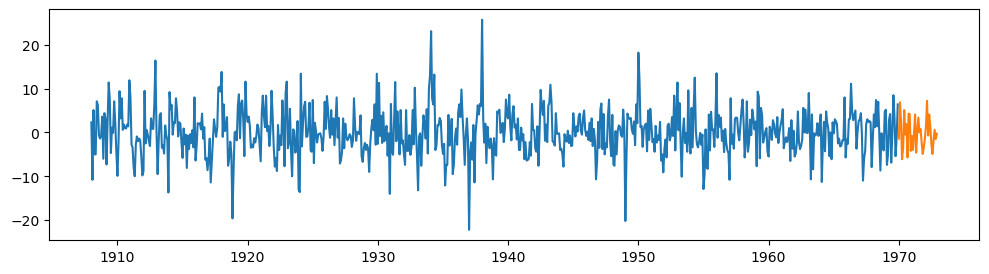

In [48]:
train = monthly_temp_clean['Seasonally_Differenced'][:-36]
test = monthly_temp_clean['Seasonally_Differenced'][-36:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [51]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Seasonally_Differenced   No. Observations:                  744
Model:                     ARIMA(3, 0, 3)   Log Likelihood               -2248.077
Date:                    Wed, 10 Apr 2024   AIC                           4512.155
Time:                            21:46:15   BIC                           4549.051
Sample:                        01-01-1908   HQIC                          4526.377
                             - 12-01-1969                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0643      0.244      0.264      0.792      -0.414       0.542
ar.L1         -0.0970      0.143     -0.678      0.498      -0.377       0.183
ar.L2         -0.828

### ARMA Model Validation

- How do you know if your ARMA model is any good?
- We can check the resiudals, i.e., the parts the model was not able to fit.
- The residuals should approximate a Gaussian distribution (aka white noise).
- Otherwise, we might need to select a better model.

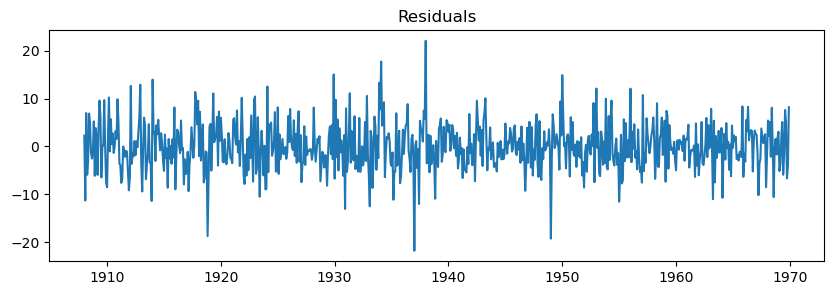

In [53]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

**🤔 How to test if the residuals look like noise?**

- We will use both visual inspection and statistical tests.
- Visual inspection:
    - ACF plot
    - Histogram
    - QQ plot
- Statistical tests:
    - Normality
    - Autocorrelation
    - Heteroskedasticity

#### Visual inspection 

**ACF plot**

- Checks for any autocorrelation in the residuals. 
- White noise should show no significant autocorrelation at all lags.

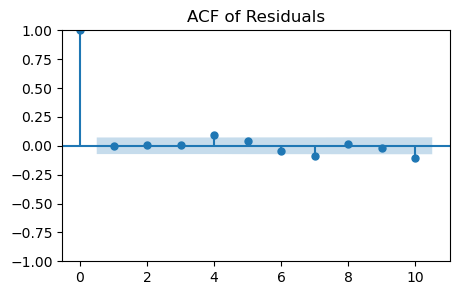

In [74]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(residuals, lags=10, ax=ax)
plt.title('ACF of Residuals')
plt.show()

**Histogram and QQ-Plot**
- Assess the normality of the residuals. 
- White noise should ideally follow a normal distribution.

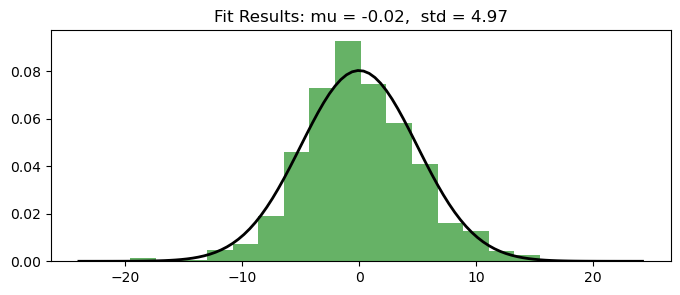

In [57]:
# Histogram
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g')
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title)
plt.show()

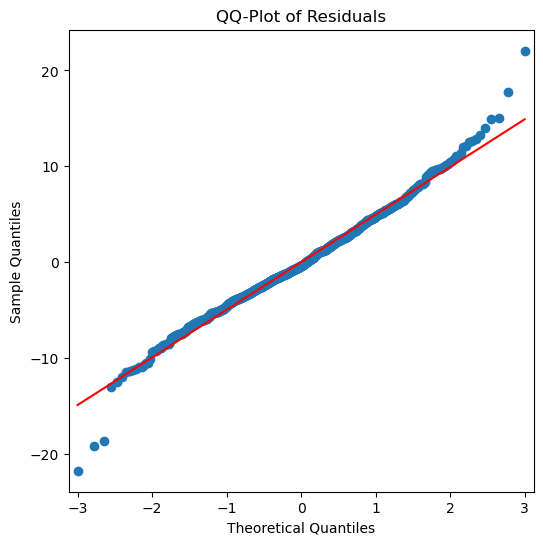

In [60]:
# QQ-Plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
qqplot(residuals, line='s', ax=ax)
plt.title('QQ-Plot of Residuals')
plt.show()

- The plots are conveniently summarized in the function ``plot_diagnostics()`` that can be called on the fit model.

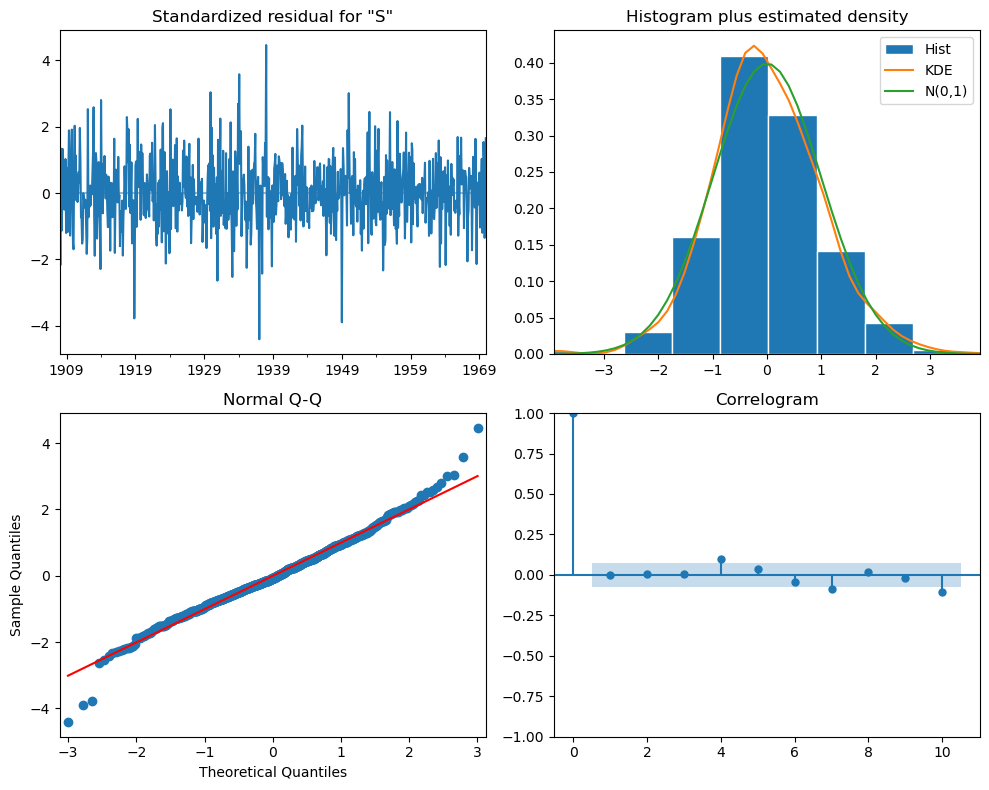

In [76]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

#### Statistical tests

**Normality: Jarque-Bera and Shapiro-Wilk tests**

> $H_0$: the residuals are normally distributed.

In [62]:
norm_val, norm_p, skew, kurtosis = fit_model.test_normality('jarquebera')[0]
print('Normality (Jarque-Bera) p-value:{:.3f}'.format(norm_p))

Normality (Jarque-Bera) p-value:0.000


In [63]:
shapiro_test = stats.shapiro(residuals)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Shapiro-Wilk) p-value: 0.000


- The small p-values allow us to reject $H_0$.
- Conclusion: the residuals are **not** normally distributed.

**📝 Note**
- For reference, let's see what these tests say about data that are actually normally distributed.
- Try executing the cell below multiple times and see how much the results changes each time.
- These tests start to be reliable only for large sample sizes ($N>5000$).

In [73]:
# generate random normal data
normal_data = np.random.normal(loc=0, scale=1, size=1000)

jb_test = stats.jarque_bera(normal_data)
print(f'Normality (Jarque-Bera) p-value: {jb_test.pvalue:.3f}')

shapiro_test = stats.shapiro(normal_data)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Jarque-Bera) p-value: 0.425
Normality (Shapiro-Wilk) p-value: 0.309


**Autocorrelation: Ljung-Box Test**

> $H_0$: the residuals are independently distributed (no autocorrelation).

- There is a p-value for each lag. 
- Here we just take the mean, but one might also want to look at the at largest lag (`pval[-1]`).
- It is also not always obvious to select how many lags should be used in the test...

In [31]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}') 

Ljung-Box p-value: 0.360


**Autocorrelation: Durbin Watson**

- Tests autocorrelation in the residuals.
- We want something between 1-3, 2 is ideal (no serial correlation).

In [32]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=1.99


**Heteroskedasticity**

- Tests for change in variance between residuals.
> $H_0$: no heteroskedasticity. 
- $H_0$ indicates different things based on the alternative $H_A$:
    - $H_A$: Increasing, $H_0$ the variance is not decreasing throughout the series.
    - $H_A$: Decreasing, $H_0$ the variance is not increasing throughout the series.
    - $H_A$: Two-sided (default), $H_0$ the variance is not changing throughout the srries.

In [83]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.981


In [84]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.019


In [85]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.038


**Summary of our tests**

Independence
- &#x2705; ACF plot
- &#x2705; Ljung-Box test
- &#x2705; Durbin Watson

Normality:
- &#x2705; Histogram/Density plot
- 🤔 QQ-plot
- &#x274C; Jarque-Bera (reliable for large sample size)
- &#x274C; Shapiro-Wilk (reliable for large sample size)

Heteroskedasticity
- &#x274C; Heteroskedasticity test

- The tests are a bit inconclusive.
- There is no strong evidence that the model is either very good or very bad.
- It is probably wise to try other canidate models (e.g., ARMA(2,0,2)) and repeat the tests.

### ARMA Model Predictions

- Once the model is fit, we can use it to predict the test data.
- The prediction provides a distribution.
- The mean (mode) of this distribution correspond to the most likely value and correspond to our forecast
- The rest of the distribution can be used to compute confidence intervals

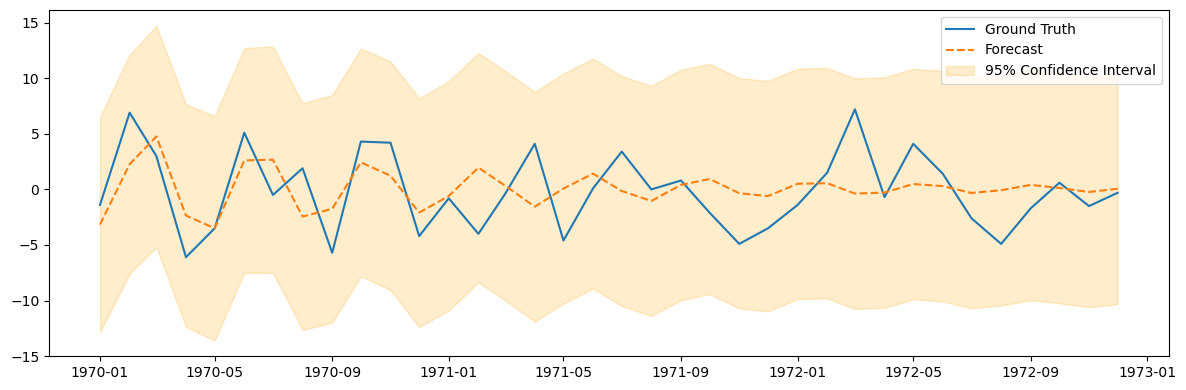

In [88]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Ground Truth')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], 
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.tight_layout();

---

## ARIMA Model

- ARIMA stands for Auto Regressive Integrated Moving Average. 
- ARIMA models have three components:
    - AR model
    - Integrated component (more on this shortly)
    - MA model

- The ARIMA model is denoted ARIMA($p, d, q$).
    - $p$ is the order of the AR model.
    - $d$ is the number of times to difference the data.
    - $q$ is the order of the MA model.
    - $p$, $d$, and $q$ are nonnegative integers.

- As we saw previously, differencing nonstationary time series data one or more times can make it stationary. 
- That’s the role of the integrated (I) component of ARIMA.
- $d$ is the number of times to perform a lag 1 difference on the data.
    - $d=0$: no differencing. 
    - $d=1$: difference once. 
    - $d=2$: difference twice. 

- The ARMA model is suitable for the stationary series where the mean and variance do not change over time.
- The ARIMA model effectively models the non-stationary series by differencing the data.
- This, transforms it into a stationary series before applying the ARMA modeling steps.
- Let's see it with an example.

In [123]:
# Generate synthetic stationary data with an ARMA(1,1) process
n = 250
ar_params = np.array([1, -0.7]) # The first value refers to lag 0 and is always 1. In addition, AR coeff are negated.
ma_params = np.array([1, 0.7])  # The first value refers to lag 0 and is always 1
arma_data = ss.tsa.arima_process.ArmaProcess(ar_params, ma_params).generate_sample(nsample=n, burnin=1000)

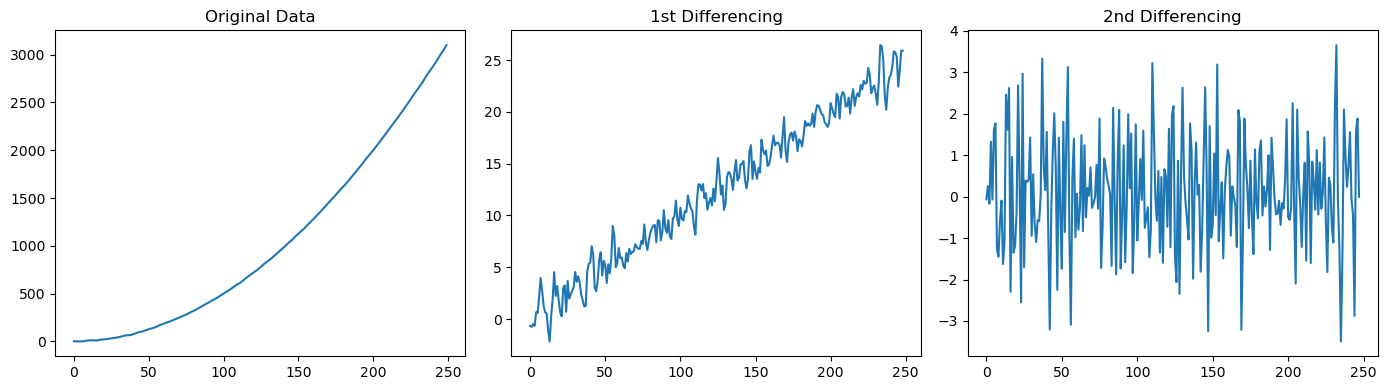

In [124]:
# Generate a synthetic non-stationary data (needs to be differenced twice to be stationary)
t = np.arange(n)
non_stationary_data = 0.05 * t**2 + arma_data  # Quadratic trend

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(non_stationary_data)
axes[0].set_title('Original Data')
axes[1].plot(diff(non_stationary_data, k_diff=1))
axes[1].set_title('1st Differencing')
axes[2].plot(diff(non_stationary_data, k_diff=2))
axes[2].set_title('2nd Differencing')
plt.tight_layout();

220


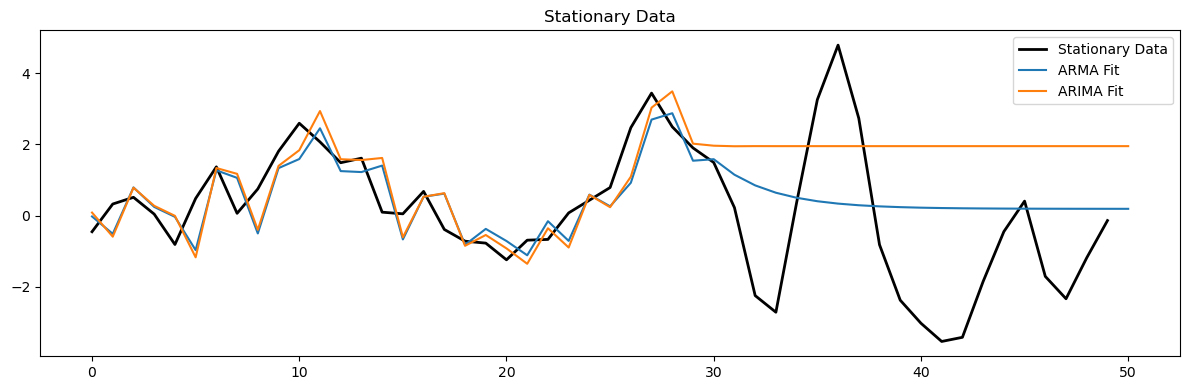

In [133]:
# Fit models to stationary data
arma_model = ARIMA(arma_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(arma_data[:-20], order=(1, 1, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(arma_data[-50:], 'k', label='Stationary Data', linewidth=2)
plt.plot(arma_model.predict(200,250), label='ARMA Fit')
plt.plot(arima_model.predict(200, 250), label='ARIMA Fit')
plt.legend()
plt.title('Stationary Data')
plt.tight_layout();

print(len(arma_model.predict(10)))

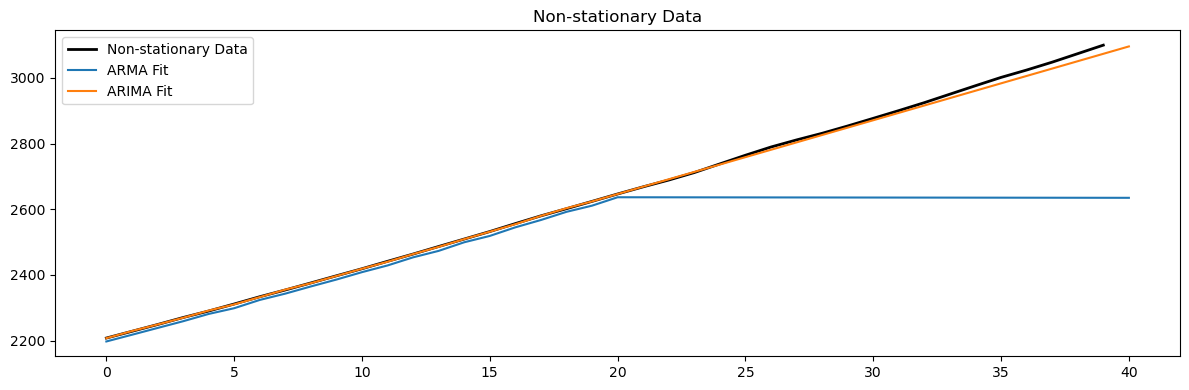

In [132]:
# Fit models to non-stationary data
arma_model = ARIMA(non_stationary_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(non_stationary_data[:-20], order=(1, 2, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(non_stationary_data[-40:], 'k', label='Non-stationary Data', linewidth=2)
plt.plot(arma_model.predict(210,250), label='ARMA Fit')
plt.plot(arima_model.predict(210,250), label='ARIMA Fit')
plt.legend()
plt.title('Non-stationary Data')
plt.tight_layout();

---

## SARIMA

- To apply ARMA and ARIMA, we had to remove the seasonal component.
- After computing the predictions, we had to put the seasonal component back.
- It would be convenient to directly work on data with seasonality.

- SARIMA is an extension of ARIMA that includes seasonal terms.
- The model is specified as SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Regular ARIMA components $(p, d, q)$.
  - Seasonal components $(P, D, Q, s)$ where:
    - $P$: Seasonal autoregressive order.
    - $D$: Seasonal differencing order.
    - $Q$: Seasonal moving average order.
    - $s$: Number of time steps for a single seasonal period.

**How to select the SARIMA  parameters $s, P, D, Q$?**
- $s$: 
    - Is the main seasonality in the data. 
    - We've seen already how to detect it.
- $P$ and $Q$: 
    - A bar at $s$-th lag (and potentially multiples of $s$) should be present. 
    - For example, if $s = 12$, there could be bars at $(s*n)^{th}$ lags too. 
    - Pick out the few lags of largest values as candidates for $P$ or $Q$.
- $D$: 
    - Is the number of seasonal differencing required to make the series stationary. 
    - Often determined by trial and error, or by examining the seasonally differenced data.

**💡 Rule of thumb**
- Before selecting $P$ and $Q$, ensure that the series is seasonally stationary by applying seasonal differencing if needed ($D$). 
- Look the ACF plot to identify the seasonal moving average order $Q$. 
  - Look for significant autocorrelations at seasonal lags (multiples of $s$). 
  - If the ACF plot shows a slow decay in the seasonal lags, it suggests a need for a seasonal MA component ($Q$).
  
- Look at tge PACF plot to identify the seasonal autoregressive order $P$. 
  - Look for significant spikes at multiples of the seasonality $s$. 
  - A sharp cut-off in the PACF at a seasonal lag suggests the number of AR terms ($P$) needed.

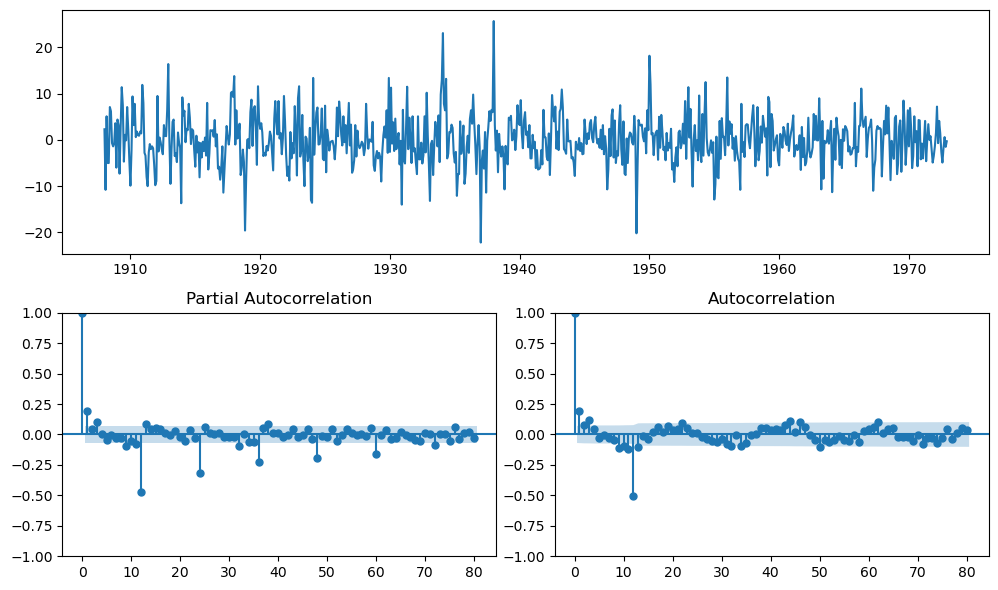

In [138]:
diff_ts = monthly_temp['temp'].diff(periods=12).dropna()

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(diff_ts)
ax2 = plt.subplot2grid((2, 2), (1, 0))
plot_pacf(diff_ts, lags=80, ax=ax2)
ax3 = plt.subplot2grid((2, 2), (1, 1))
plot_acf(diff_ts, lags=80, ax=ax3)
plt.tight_layout();

In [139]:
# fit SARIMA monthly based on helper plots
sar = ss.tsa.statespace.sarimax.SARIMAX(monthly_temp[:750].temp, 
                                order=(2,1,2), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit(disp=False)
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  750
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2026.063
Date:                              Wed, 10 Apr 2024   AIC                           4066.126
Time:                                      23:02:47   BIC                           4098.344
Sample:                                  01-01-1907   HQIC                          4078.550
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.665e-05      0.000     -0.373      0.709      -0.000       0.000
ar.L1         -0.7659      0.171     -4.488      0.000      -1.100      -0.431
ar.L2          0.1790      0.042      4.258      0.000       0.097       0.261
ma.L1         -0.0543      0.182     -0.298      0.766      -0.412       0.303
ma.L2         -0.9434      0.174     -5.438      0.000      -1.283      -0.603
ma.S.L12      -0.9816      0.039    -24.881      0.000      -1.059      -0.904
sigma2        13.3630      0.957     13.959      0.000      11.487      15.239
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               202.08
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.55
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

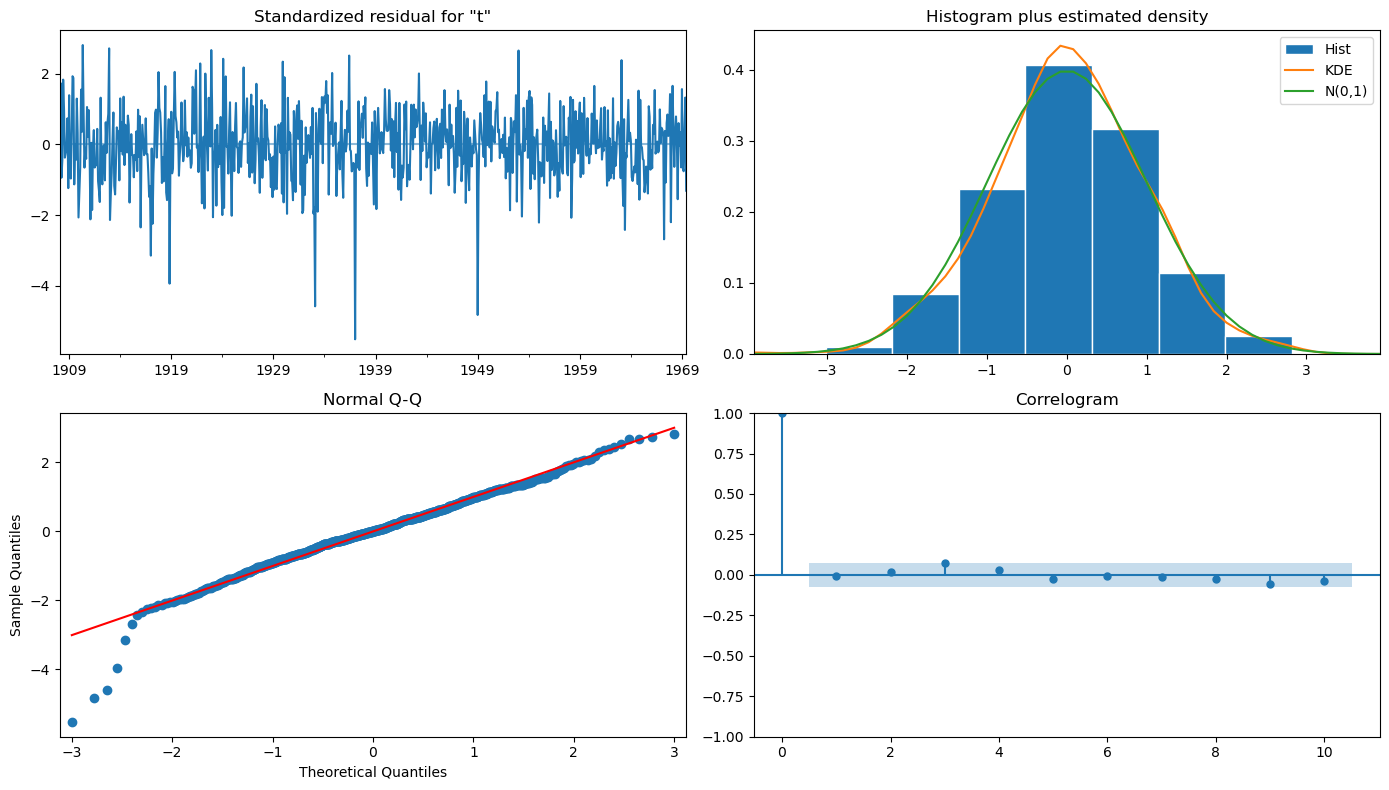

In [143]:
sar.plot_diagnostics(figsize=(14, 8))
plt.tight_layout();

MSE: 9.21


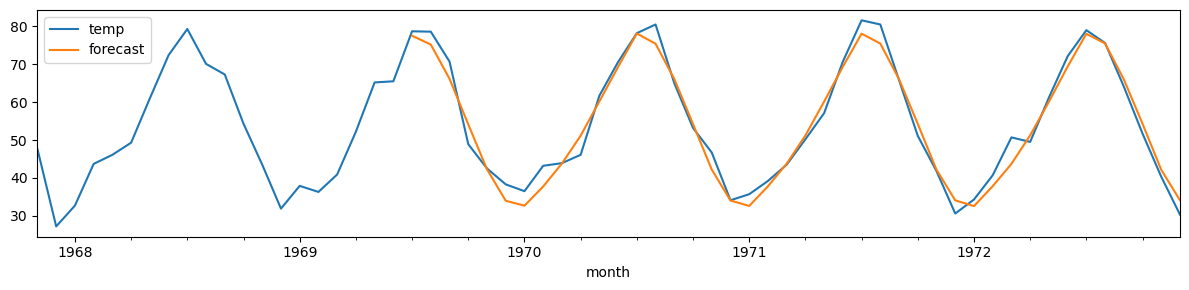

In [151]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 792, dynamic=False)  
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

## AutoARIMA

- At this point it should be clear that indetifying the coefficients is a difficult task.
- It requires careful analysis, trial and errors, and some experience.
- The following cheatsheet summarizes some rules of thumbs to select the model.

**💡 Cheatsheet: coefficients setting**

<center>
    
|ACF Shape|Indicated Model|
|---|:---|
|Exponential, decaying to zero|AR model. Use the PACF to identify the order of the ARe model.|
|Alternating positive and negative, decaying to zero|AR model. Use the PACF to identify the order.|
|One or more spikes, rest are essentially zero|MA model, order identified by where plot becomes zero.|
|Decay, starting after a few lags|Mixed AR and MA (ARMA) model.|
|All zero or close to zero|Data are essentially random.|
|High values at fixed intervals|Include seasonal AR term.|
|No decay to zero|Series is not stationary.|
    
</center>

- An alternative to manual model selection is to use automated procedure.
- Here enters AutoARIMA.
- AutoARIMA requires you to specify the maximum range of values to try.
- Afterwards, it tries to find the best confgiuration among the possible ones.
- See [here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for a complete list and description of the options available.

In [152]:
# Split the data into train and test sets
train, test = monthly_temp[:750].temp, monthly_temp[750:].temp

# Use auto_arima to find the best ARIMA model
model = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=2, max_q=2, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4558.569, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4318.918, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4556.588, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4531.290, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4230.055, Time=1.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4256.241, Time=1.54 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4230.500, Time=1.78 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4228.386, Time=1.93 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4317.592, Time=0.87 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.66 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  750
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -2108.234
Date:                             Wed, 10 Apr 2024   AIC                           4226.467
Time:                                     23:19:53   BIC                           4249.487
Sample:                                 01-01-1907   HQIC                          4235.344
                                      - 06-01-1969                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5814      0.144      4.027      0.000       0.298       0.864
ma.L1         -0.4101      

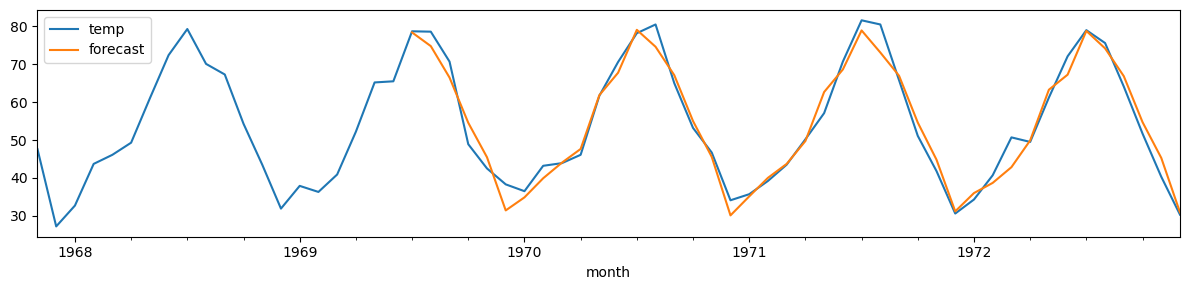

In [153]:
# Summarize the model
print(model.summary())

# Frecast future values
monthly_temp['forecast'] = model.predict(n_periods=len(test)) 
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout();
print(f"MSE: {mse(monthly_temp['temp'][-42:],monthly_temp['forecast'][-42:]):.2f}")

### AutoARIMA or not AutoARIMA?

While being very convenient, like all automated procedures `auto_arima` comes with drawbacks.

1. **Computational Cost** 
    - `auto_arima` can be computationally expensive, especially for large datasets and when exploring a wide range of model parameters. 

2. **Lack of Domain Insight** 
    - Automated model selection lacks the qualitative insights a human might bring to the modeling process, such as understanding business cycles, external factors, or anomalies in the data. 
    - These insights can be crucial for selecting the appropriate model, especially with limited data.

3. **Default Settings and Assumptions**
    - The defaults in `auto_arima` may not be optimal for all time series data. 
    - The choice of stationarity tests, seasonal tests, and the range of parameters explored should be adjusted properly for each context.
    - This might become almost as complicated as doing manual model selection.

4. **Data Requirements**
    - `auto_arima` requires a sufficiently long time series to accurately identify patterns and seasonality. 
    - For very short time series, the model selection process may not be reliable.

5. **Statistical Criteria Limitations** 
    - The selection of the best model is typically based on statistical criteria such as AIC or BIC, which might not always align with practical performance metrics such as forecast accuracy.

## Grid Search

- Selecting the best ARIMA model is as much an art as it is a science, involving iteration and refinement.
- A common approach is to select a set of candidates for the parameters $(p,d,q)\times (P,D,Q,s)$ and fit a model for each possible combination.

- For each fit model:
    - Analyze the residuals using the visual techniques and the statistical tests discussed before
    - Evaluate the prediction performance. How?
    - Evaluate its complexity. How?

### Prediction performance 

Use MSE and/or MAPE to evaluate the prediction performance of the model.

**Mean Squared Error (MSE)**

- MSE is the average of the squared differences between the observed values and the predictions.
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- In SARIMA model selection, a model with a lower MSE is preferred, indicating better fit to the data.

**Mean Absolute Percentage Error (MAPE)**

- MAPE is the average of the absolute percentage errors of forecasts.
- $MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- MAPE expresses errors as a percentage, making it straightforward to understand the magnitude of forecasting errors.
- If you are comparing models that predict different quantities (e.g., dollars vs. units sold), the percentage error allows for a more apples-to-apples comparison.
- Also, when you're more interested in the relative size of the errors than in their absolute size, MAPE is relevant. 
- Finally, MAPE is useful when the magnitude of the data varies significantly.

### Model complexity

Use AIC or BIC to estimate the model's complexity.

**Akaike Information Criterion (AIC)**

- AIC is a measure of the relative quality of statistical models for a given set of data. 
- It deals with the trade-off between the goodness of fit of the model and the complexity of the model.
- $AIC = 2k - 2\ln(\hat{L})$, where $k$ is the number of parameters in the model, and $\hat{L}$ is the maximized value of the likelihood function for the model.
- The model with the lowest AIC value is preferred, as it fits the data well but is not overly complex.

**Bayesian Information Criterion (BIC)**

- Similar to AIC, the BIC is another criterion for model selection, but it introduces a stronger penalty for models with more parameters.
- $BIC = \ln(n)k - 2\ln(\hat{L})$, where $n$ is the number of observations, $k$ is the number of parameters, and $\hat{L}$ is the maximized likelihood.
- A lower BIC value indicates a better model, preferring simpler models to complex ones, especially as the sample size $n$ increases.

### Restricting the search with Exploratory Data Analysis (EDA)

- Grid search can be very expensive if done exaustively, especially on limited hardware.
- An Exploratory Data Analysis can help to significantly reduce the number of candidates to try out.

#### Selecting the candidates for differentiation

- Let's start by identifying all the candidates for seasonal and general differencing.
- In this case, we already know that the main seasionality is $s=12$. 
- Should we apply first the general or the seasonal differencing?

**💡 Hint**

- If seasonal patterns are dominant and the goal is to remove seasonality before addressing any trend, start with **seasonal differencing**. 
    - This is particularly useful when the seasonal pattern is strong and clear.
- If the trend is the predominant feature, you might start with **standard differencing**.

- In our case, we go with seasonal differencing first.

In [157]:
# create all combinations of differencing orders, applying seasonal differencing first and then general differencing
def differencing(timeseries, s, D_max=2, d_max=2):
        
    # Seasonal differencing from 0 to D_max
    seas_differenced = []
    for i in range(D_max+1):
        timeseries.name = f"d0_D{i}_s{s}"
        seas_differenced.append(timeseries)
        timeseries = timeseries.diff(periods=s)
    seas_df = pd.DataFrame(seas_differenced).T

    # General differencing from 0 to d_max
    general_differenced = []
    for j, ts in enumerate(seas_differenced):
        for i in range(1,d_max+1):
            ts = ts.diff()
            ts.name = f"d{i}_D{j}_s{s}"
            general_differenced.append(ts)       
    gen_df = pd.DataFrame(general_differenced).T
    
    # concatenate seasonal and general differencing dataframes
    return pd.concat([seas_df, gen_df], axis=1)

In [158]:
# create the differenced series
diff_series = differencing(monthly_temp['temp'], s=12, D_max=2, d_max=2)
diff_series

,d0_D0_s12,d0_D1_s12,d0_D2_s12,d1_D0_s12,d2_D0_s12,d1_D1_s12,d2_D1_s12,d1_D2_s12,d2_D2_s12
month,,,,,,,,,
1907-01-01,33.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907-02-01,46.0,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN
1907-03-01,43.0,NaN,NaN,-3.0,-15.7,NaN,NaN,NaN,NaN
1907-04-01,55.0,NaN,NaN,12.0,15.0,NaN,NaN,NaN,NaN
1907-05-01,51.8,NaN,NaN,-3.2,-15.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1972-08-01,75.6,-4.9,-4.9,-3.4,-10.3,-2.3,1.7,1.1,8.4
1972-09-01,64.1,-1.7,-2.5,-11.5,-8.1,3.2,5.5,2.4,1.3
1972-10-01,51.7,0.6,2.7,-12.4,-0.9,2.3,-0.9,5.2,2.8


#### Filter-out non-stationary candidates

- Among all the differenced time series, keep only those that are stationary (according to ADF)

In [159]:
# create a summary of test results of all the series
def adf_summary(diff_series):
    summary = []
    
    for i in diff_series:
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)
    
    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)
    
    return summary

In [160]:
# create the summary
summary = adf_summary(diff_series)

# filter away results that are not stationary
summary_passed = summary[summary["p-value"] < 0.05]
summary_passed

,Test Statistic,p-value,#Lags Used,No. of Obs. Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
d0_D0_s12,-6.481466,1.291867e-08,21,770,-3.438871,-2.865301,-2.568773
d0_D1_s12,-12.658082,1.323220e-23,12,767,-3.438905,-2.865316,-2.568781
d0_D2_s12,-10.416254,1.751310e-18,14,753,-3.439064,-2.865386,-2.568818
d1_D0_s12,-12.302613,7.391771e-23,21,769,-3.438882,-2.865306,-2.568775
d2_D0_s12,-15.935084,7.651998e-29,17,772,-3.438849,-2.865291,-2.568767
d1_D1_s12,-11.846173,7.390517e-22,20,758,-3.439006,-2.865361,-2.568804
d2_D1_s12,-18.352698,2.234953e-30,21,756,-3.439029,-2.865371,-2.568810
d1_D2_s12,-12.221559,1.104309e-22,20,746,-3.439146,-2.865422,-2.568837
d2_D2_s12,-15.080476,8.468854e-28,20,745,-3.439158,-2.865427,-2.568840


In [161]:
# output indices as a list
index_list = pd.Index.tolist(summary_passed.index)

# use the list as a condition to keep stationary time-series
passed_series = diff_series[index_list].sort_index(axis=1)

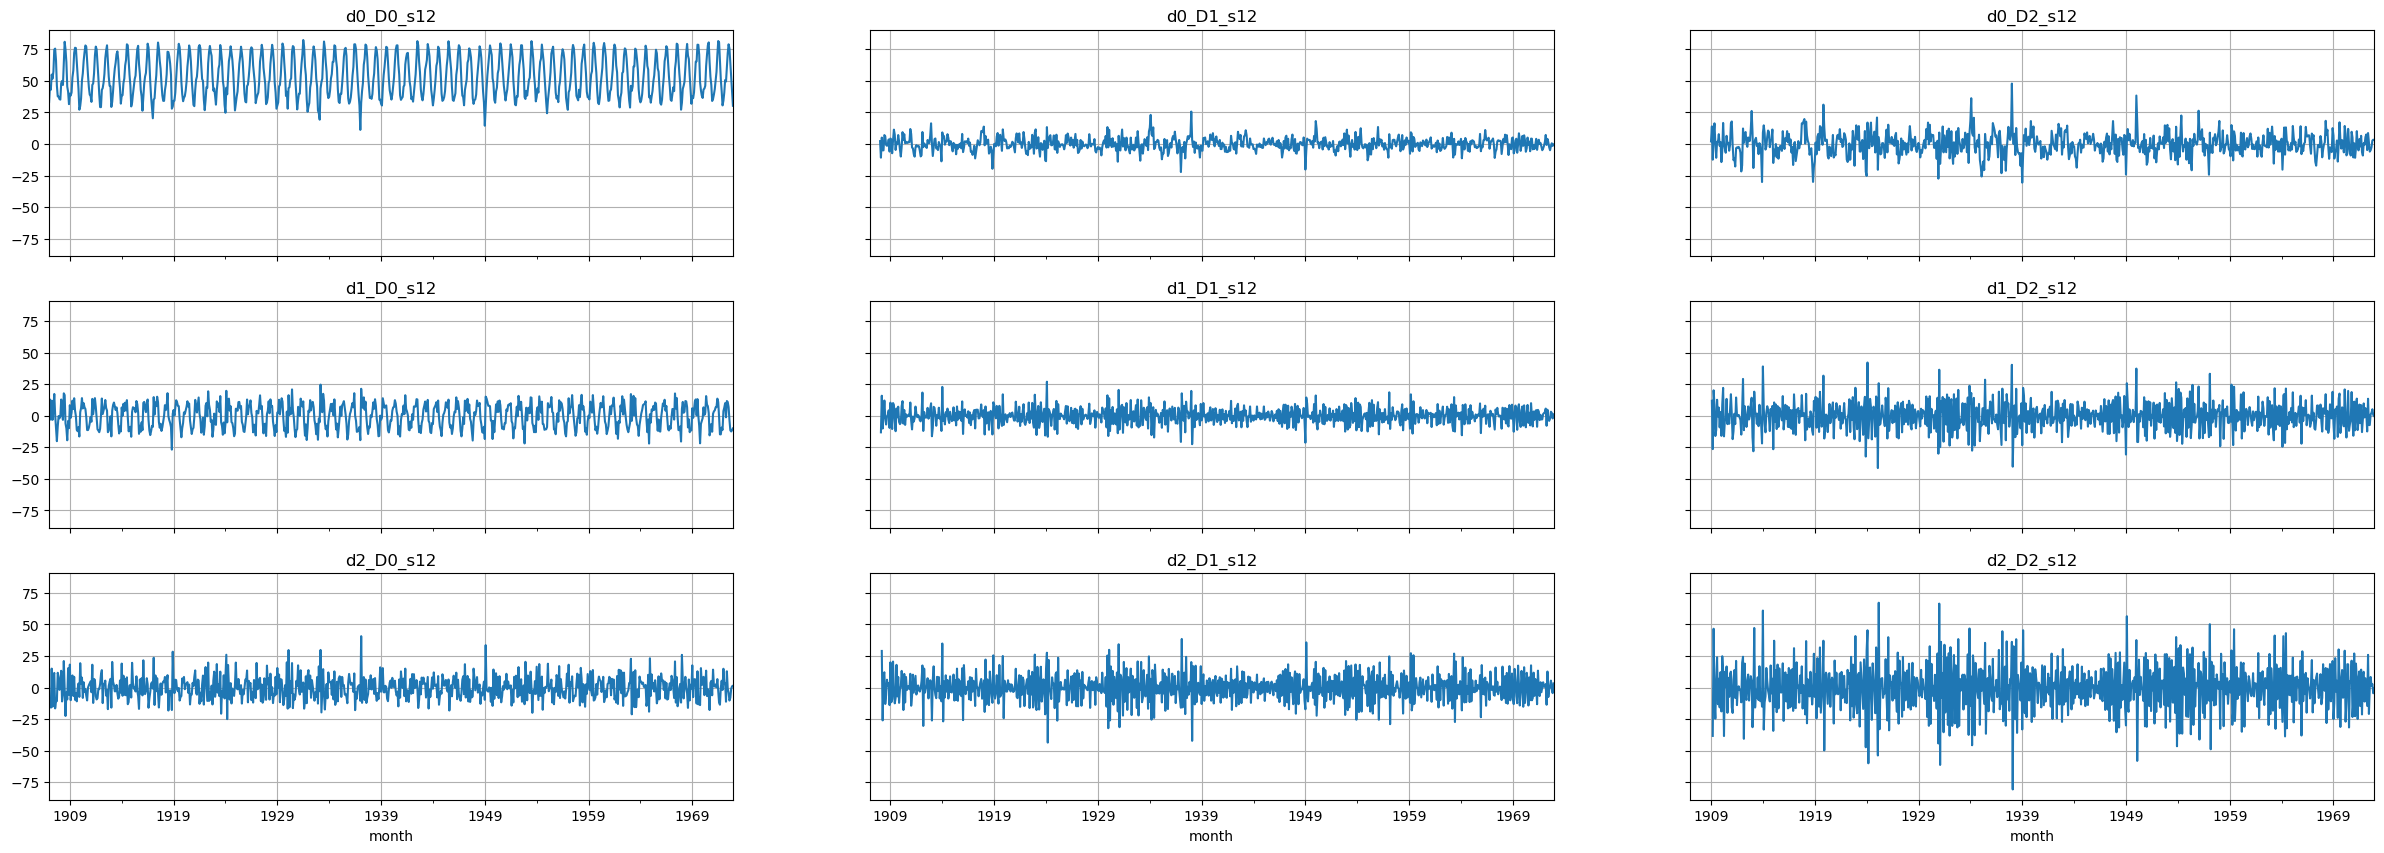

In [162]:
# Plot the final set of time series 
# NOTE: these plots are too small. Make a larger plot for each series to see things better!
fig, axes = plt.subplots(3, 3, figsize=(30, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    passed_series.iloc[:,i].plot(ax=ax)
    ax.set_title(passed_series.columns[i])
    ax.grid()

#### Select candidates for orders $p, q, P, Q$

- We are going to make a script to extract canidates for the orders of the AR and MA component, both in the general and the seasonal part.
- We will leverage the ACF and PACF functions.
- So far, we looked at the `acf_plot` and `pacf_plot`.
- Now we need to use `acf` and `pacf`.
- We need to understand how these relate.

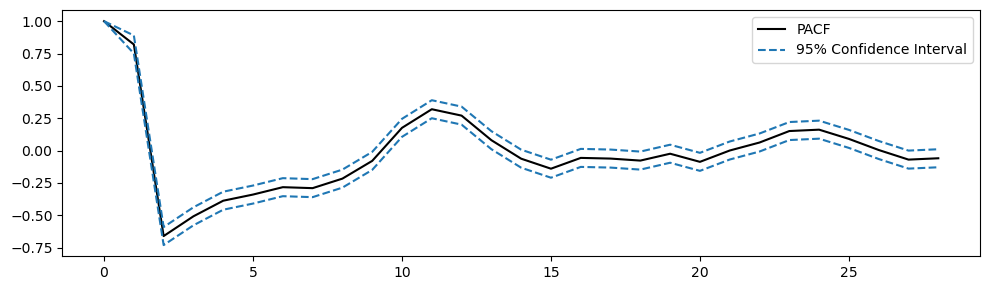

In [164]:
PACF, PACF_ci = pacf(passed_series.iloc[:,0].dropna(), alpha=0.05)

# Plot PACF
plt.figure(figsize=(10,3))
plt.plot(PACF, color='k', label='PACF')
plt.plot(PACF_ci, color='tab:blue', linestyle='--', label=['95% Confidence Interval', ''])
plt.legend()
plt.tight_layout();

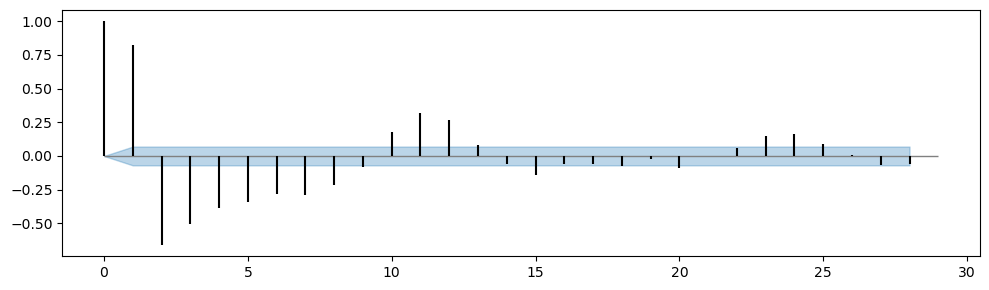

In [165]:
# subtract the confidence interval from the PACF to center the CI in zero
plt.figure(figsize=(10,3))
plt.fill_between(range(29), PACF_ci[:,0] - PACF, PACF_ci[:,1] - PACF, color='tab:blue', alpha=0.3)
plt.hlines(y=0.0, xmin=0, xmax=29, linewidth=1, color='gray')

# Display the PACF as bars
plt.vlines(range(29), [0], PACF[:29], color='black')
plt.tight_layout();

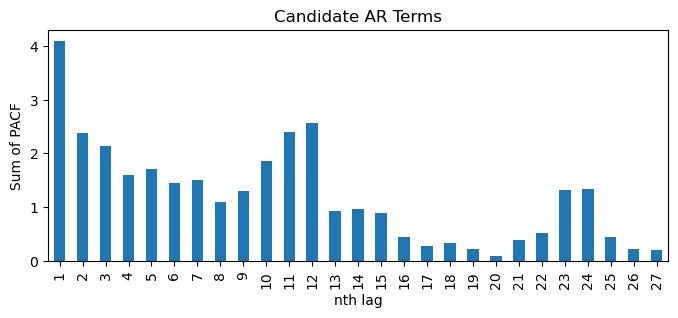

In [166]:
df_sp_p = pd.DataFrame() # create an empty dataframe to store values of significant spikes in PACF plots
for i in passed_series:
    # unpack the results into PACF and their CI
    PACF, PACF_ci = pacf(passed_series[i].dropna(), alpha=0.05, method='ywm')
    
    # subtract the upper and lower limits of CI by PACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF
        
    # find positions of significant spikes representing possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]
        
    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]
    
    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_p = df_sp_p.sort_index()

# visualize sums of values of significant spikes in PACF plots ordered by lag
df_sp_p.iloc[1:].T.sum().plot(kind='bar', title='Candidate AR Terms', xlabel='nth lag', ylabel='Sum of PACF', figsize=(8,3));

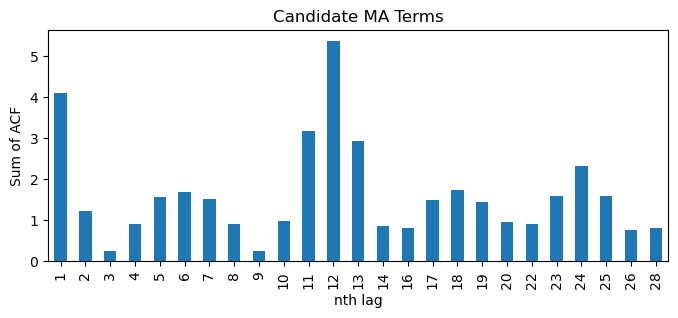

In [167]:
df_sp_q = pd.DataFrame()
for i in passed_series:
    # unpack the results into ACF and their CI
    ACF, ACF_ci = acf(passed_series[i].dropna(), alpha=0.05)
    
    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF
    
    # find positions of significant spikes representing possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]
    
    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]
    
    # store values to dataframe
    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# Sort the dataframe by index
df_sp_q = df_sp_q.sort_index()

# visualize sums of values of significant spikes in ACF plots ordered by lags
df_sp_q.iloc[1:].T.sum().plot(kind='bar', title='Candidate MA Terms', xlabel='nth lag', ylabel='Sum of ACF', figsize=(8,3));

#### Define the grid of hyperparameters to search

In [169]:
# possible values of the parameters
p = [1, 2, 3]
d = [0, 1]
q = [1, 2]
P = [0, 1]
D = [0, 1, 2]
Q = [0, 1]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQm = list(product(P, D, Q, s))

print(f"Number of total combinations: {len(pdq)*len(PDQm)}")

Number of total combinations: 144


#### Train the models

- We defined a function that takes every parameter configuration and trains a model.
- For each model, we save the MSE, MAPE, AIC and BIC.

In [170]:
warnings.simplefilter("ignore")
def SARIMA_grid(endog, order, seasonal_order):

    # create an empty list to store values
    model_info = []
       
    #fit the model
    for i in tqdm(order):
        for j in seasonal_order:
            try:
                model_fit = SARIMAX(endog=endog, order=i, seasonal_order=j).fit(disp=False)
                predict = model_fit.predict()
            
                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((endog-predict)[1:])/(endog[1:])).mean()
                MSE = mse(endog[1:], predict[1:])
                AIC = model_fit.aic
                BIC = model_fit.bic
            
                # save order, seasonal order & evaluation metrics
                model_info.append([i, j, MAPE, MSE, AIC, BIC])
            except:
                continue
                
    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "MSE", "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

In [171]:
# create train-test-split
train = monthly_temp['temp'].iloc[:int(len(monthly_temp)*0.9)]
test = monthly_temp['temp'].iloc[int(len(monthly_temp)*0.9):]

In [172]:
start = time.time()

# fit all combinations into the model
model_info = SARIMA_grid(endog=train, order=pdq, seasonal_order=PDQm)

end = time.time()
print(f'time required: {end - start}')

100%|████████████████████████████████████████| 12/12 [05:17<00:00, 26.49s/it]

time required: 317.9590229988098:.2f


#### Analyze the results

- Show the 10 best models according to the performance (MSE, MAPE) and model complexity (AIC, BIC)

In [173]:
# 10 least MAPE models
least_MAPE = model_info.nsmallest(10, "MAPE")
least_MAPE

,order,seasonal_order,MAPE,MSE,AIC,BIC
138,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776997,3860.355285,3896.752491
44,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774515,3855.635011,3882.932916
126,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741020,3856.094655,3887.942211
132,"(3, 1, 2)","(0, 1, 1, 12)",0.069124,16.792479,3859.587810,3891.435365
79,"(2, 1, 1)","(1, 1, 1, 12)",0.069125,16.802744,3857.201685,3884.499590
39,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781157,3854.505170,3877.253424
120,"(3, 1, 1)","(0, 1, 1, 12)",0.069167,16.746297,3854.844888,3882.142792
90,"(2, 1, 2)","(1, 1, 1, 12)",0.069172,16.805184,3860.077595,3891.925151
74,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811222,3856.177062,3878.925316
33,"(1, 1, 1)","(1, 1, 1, 12)",0.069219,16.827006,3856.771035,3879.519289


In [174]:
# 10 least MSE models
least_MSE = model_info.nsmallest(10, "MSE")
least_MSE

,order,seasonal_order,MAPE,MSE,AIC,BIC
126,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741020,3856.094655,3887.942211
120,"(3, 1, 1)","(0, 1, 1, 12)",0.069167,16.746297,3854.844888,3882.142792
44,"(1, 1, 2)","(1, 1, 1, 12)",0.069051,16.774515,3855.635011,3882.932916
138,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776997,3860.355285,3896.752491
39,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781157,3854.505170,3877.253424
132,"(3, 1, 2)","(0, 1, 1, 12)",0.069124,16.792479,3859.587810,3891.435365
79,"(2, 1, 1)","(1, 1, 1, 12)",0.069125,16.802744,3857.201685,3884.499590
90,"(2, 1, 2)","(1, 1, 1, 12)",0.069172,16.805184,3860.077595,3891.925151
74,"(2, 1, 1)","(0, 1, 1, 12)",0.069203,16.811222,3856.177062,3878.925316
85,"(2, 1, 2)","(0, 1, 1, 12)",0.069289,16.825127,3859.565037,3886.862942


In [175]:
# 10 least AIC models
least_AIC = model_info.nsmallest(10, "AIC")
least_AIC

,order,seasonal_order,MAPE,MSE,AIC,BIC
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,61.471329,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,61.482998,3847.914835,3870.670236
50,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,61.485309,3847.985625,3870.741026
96,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,61.449767,3848.292676,3875.599158
21,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,61.461761,3848.568559,3875.875041
56,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,61.464317,3848.650344,3875.956826
114,"(3, 0, 2)","(1, 1, 1, 12)",0.080090,61.400135,3849.068696,3885.477339
102,"(3, 0, 1)","(1, 1, 1, 12)",0.080096,61.430629,3849.069448,3880.927010
62,"(2, 0, 2)","(0, 1, 1, 12)",0.080282,61.469826,3849.361800,3876.668282


In [176]:
# 10 least BIC models
least_BIC = model_info.nsmallest(10, "BIC")
least_BIC 

,order,seasonal_order,MAPE,MSE,AIC,BIC
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
9,"(1, 0, 1)","(1, 1, 1, 12)",0.080153,61.471329,3846.879649,3869.635051
15,"(1, 0, 2)","(0, 1, 1, 12)",0.080286,61.482998,3847.914835,3870.670236
50,"(2, 0, 1)","(0, 1, 1, 12)",0.080283,61.485309,3847.985625,3870.741026
27,"(1, 1, 1)","(0, 1, 1, 12)",0.069317,16.836778,3855.816712,3874.015315
96,"(3, 0, 1)","(0, 1, 1, 12)",0.080295,61.449767,3848.292676,3875.599158
21,"(1, 0, 2)","(1, 1, 1, 12)",0.080146,61.461761,3848.568559,3875.875041
56,"(2, 0, 1)","(1, 1, 1, 12)",0.080145,61.464317,3848.650344,3875.956826
62,"(2, 0, 2)","(0, 1, 1, 12)",0.080282,61.469826,3849.361800,3876.668282
39,"(1, 1, 2)","(0, 1, 1, 12)",0.069130,16.781157,3854.505170,3877.253424


- We can check if there are overlaps between the 4 different groups using the `set` function

In [177]:
set(least_MAPE.index) & set(least_MSE.index)

{39, 44, 74, 79, 90, 120, 126, 132, 138}

In [178]:
set(least_AIC.index) & set(least_BIC.index)

{3, 9, 15, 21, 50, 56, 62, 96}

In [179]:
set(least_MSE.index) & set(least_AIC.index)

set()

- Show the top model according to each metric

In [180]:
# the best model by each metric
L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
L2 = model_info[model_info.MSE == model_info.MSE.min()]
L3 = model_info[model_info.AIC == model_info.AIC.min()]
L4 = model_info[model_info.BIC == model_info.BIC.min()]

best_models = pd.concat((L1, L2, L3, L4))
best_models

,order,seasonal_order,MAPE,MSE,AIC,BIC
138,"(3, 1, 2)","(1, 1, 1, 12)",0.069033,16.776997,3860.355285,3896.752491
126,"(3, 1, 1)","(1, 1, 1, 12)",0.069079,16.741020,3856.094655,3887.942211
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212
3,"(1, 0, 1)","(0, 1, 1, 12)",0.080283,61.491561,3846.181890,3864.386212


#### Compute performance on the test set

- Take the best models, compute the predictions and evaluate their performance in terms of MAPE on the w.r.t. test data.

In [181]:
# Take the parameters of the best models
ord_list = [tuple(best_models.iloc[i,0]) for i in range(best_models.shape[0])]
s_ord_list = [tuple(best_models.iloc[i,1]) for i in range(best_models.shape[0])]
preds, ci_low, ci_up, MAPE_test = [], [], [], []

# Fit the models and compute the forecasts
for i in range(4):
    model_fit = SARIMAX(endog=train, order=ord_list[i], 
                        seasonal_order=s_ord_list[i]).fit(disp=False) # Fit the model
    pred_summary = model_fit.get_prediction(test.index[0], 
                                            test.index[-1]).summary_frame() # Compute preds
    # Store results
    preds.append(pred_summary['mean'])
    ci_low.append(pred_summary['mean_ci_lower'][test.index])
    ci_up.append(pred_summary['mean_ci_upper'][test.index])
    MAPE_test.append((abs((test-pred_summary['mean'])/(test)).mean()))

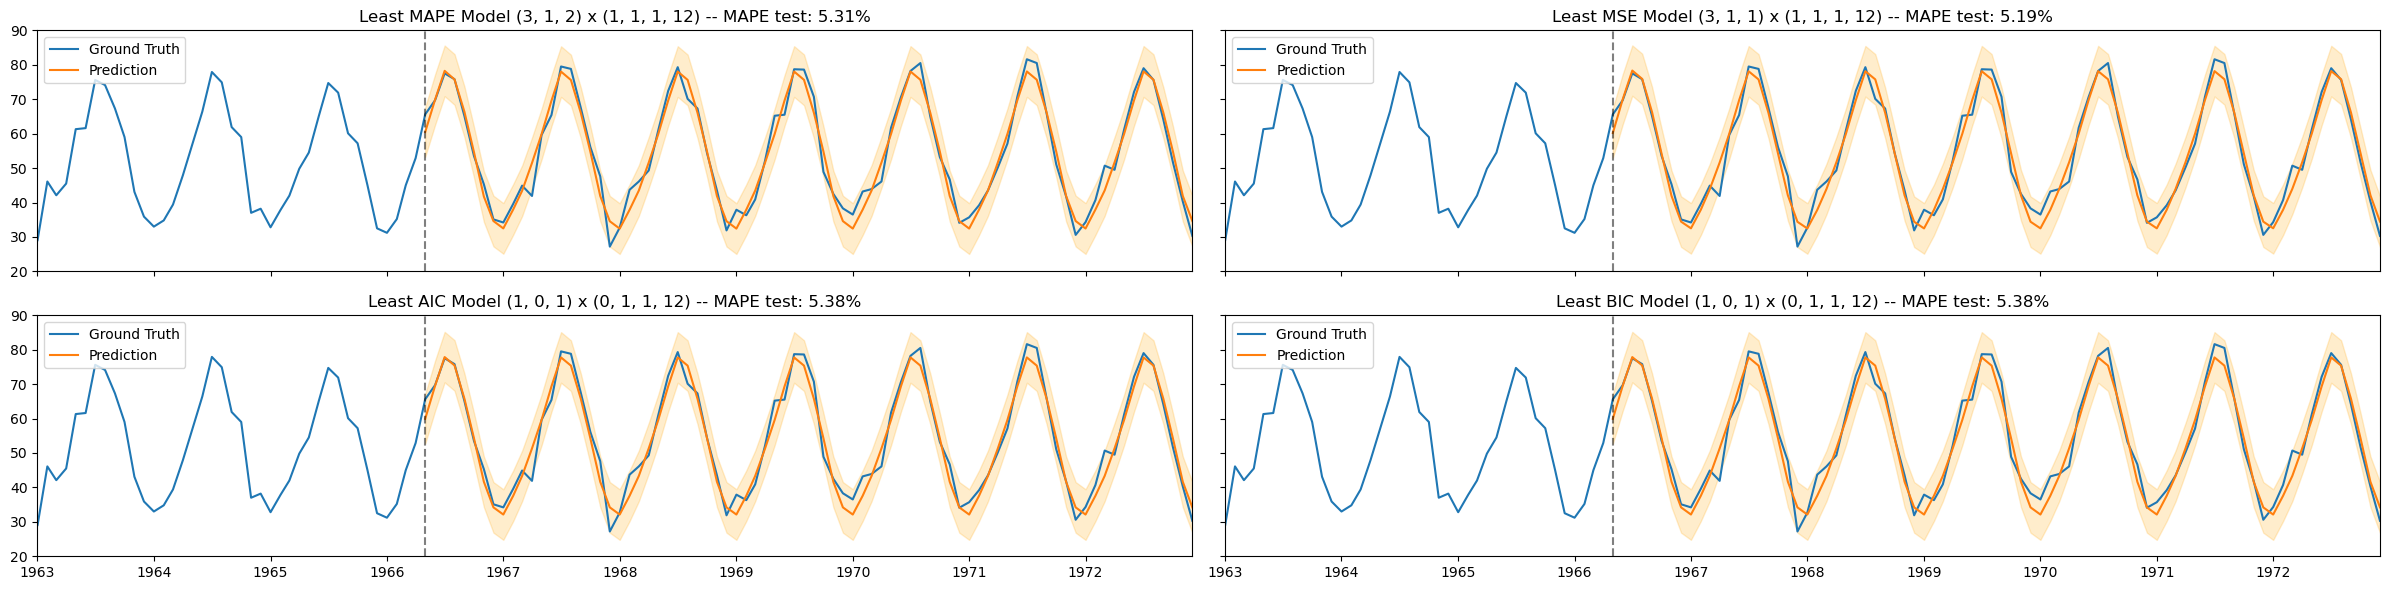

In [182]:
# visualize the results of the fitted models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24,6),
                        sharex=True, sharey=True)

titles = [f'Least MAPE Model {ord_list[0]} x {s_ord_list[0]}',
          f'Least MSE Model {ord_list[1]} x {s_ord_list[1]}',
          f'Least AIC Model {ord_list[2]} x {s_ord_list[2]}',
          f'Least BIC Model {ord_list[3]} x {s_ord_list[3]}']
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(monthly_temp['temp'], label='Ground Truth')
        axs[i,j].plot(preds[k], label='Prediction')
        axs[i,j].set_title(titles[k] + f' -- MAPE test: {MAPE_test[k]:.2%}')
        axs[i,j].legend()
        axs[i,j].axvline(test.index[0], color='black', alpha=0.5, linestyle='--')
        axs[i,j].fill_between(x=test.index, y1=ci_low[k], y2=ci_up[k], color='orange', alpha=0.2)
        axs[i,j].set_ylim(bottom=20, top=90)
        axs[i,j].set_xlim(left=monthly_temp.index[-120], right=monthly_temp.index[-1])
        k += 1
plt.tight_layout()
plt.show()

---

## Summary

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

---

## Exercise

- Look at sensor data that tracks atmospheric CO2 from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes CO2 samples from MAR 1958 to DEC 1980.

In [156]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['idx'] = pd.to_datetime(co2['idx'])
co2.set_index('idx', inplace=True)

# Rmove the name "idx" from the index column
co2.index.name = None
co2

,co2
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17
...,...
1980-08-01,337.19
1980-09-01,335.49
1980-10-01,336.63
1980-11-01,337.74


- Determine the presence of main trend and seasonality in the data.
- Determine if the data are stationary.
- Split the data in train (90%) and test (10%)
- Find a set of SARIMAX candidate models by looking at the ACF and PACF 
- Perform a grid search on the model candidates
- Select the best models, based on performance metrics, model complexity, and normality of the residuals.
- Compare the best model you found with the one from autoarima